# Project: Fraud Detection 

## 1. Overview

### PaySim simulates mobile money transactions based on a sample of real transacions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world. The objective of the project is to predict if a transaction is fraudulent or not.

## 2. Preprocess the data

#### We´ll use PySpark to preprocess the data.

In [226]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from  pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.functions import vector_to_array
import functools
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as mpt
from pyspark.sql.types import IntegerType

#from sklearn.datasets import make_classification

In [ ]:
# global variables

global df_bank, results 

In [ ]:
# creation of the SparkSession

spark = SparkSession.builder.appName("FraudDetection").getOrCreate()
spark

In [ ]:
# spark dataframe 

df = spark.read.csv('fraudDetection.csv', header=True)

#### Let´s take a look to the data with the first 10 rows.

In [ ]:
df.show(10)

In [ ]:
df.printSchema()

#### There are 11 columns, some of them are numerical and others are categorical. Let´s count the number of registers.

In [ ]:
print(f"The total number of registers is:",df.count())

#### We have more than six miliions of transactions in the dataset.

### 2.1 Feature Engineering

#### Firstly, we´ll create a function to create a new variable.

In [ ]:
### 2.1.1.- creation of a new variable: type2

df_type2 = df.withColumn("type2",f.concat(f.substring("nameOrig",1,1),f.substring("nameDest",1,1)))

In [ ]:
df_type2.show(5)

#### We´ve created a new column named "type2" which is composed by the first character of the column "nameOrig" and the first character of the column "nameDest"

In [ ]:
### 2.1.2.1.- One Hot Encoding: column "type"

df_type2.show(3)

#### We´ll use some libraries of Spark for Machine Learning (SparkML).

In [ ]:
### StringIndexer Initialization
### column: type

indexer_type = StringIndexer(inputCol="type",outputCol="types_indexed")
indexerModel_type = indexer_type.fit(df_type2)


In [ ]:
### Transform the DataFrame using the fitted StringIndexer model

indexed_df_type2 = indexerModel_type.transform(df_type2)
indexed_df_type2.show(10)

#### Here, we´ve set each of the elements of the "type" column into indexes.

In [ ]:
### apply One-Hot-Encoding to the indexed column, that is, 
### "types_indexed"

encoder_type = OneHotEncoder(dropLast=False, inputCol="types_indexed", outputCol="types_onehot")
encoder_type_df = encoder_type.fit(indexed_df_type2).transform(indexed_df_type2)
encoder_type_df.show(truncate=False)


In [ ]:
encoder_type_df.printSchema()

In [ ]:
encoder_type_df_split = encoder_type_df.select('*',vector_to_array('types_onehot').alias('types_onehot_split'))
encoder_type_df_split.show(5)

In [ ]:
### now, we´ll split the "types_onehot_split" into five columns, one per category

num_categories = len(encoder_type_df_split.first()['types_onehot_split'])
cols_expanded = [(f.col('types_onehot_split')[i].alias(f"{indexerModel_type.labels[i]}")) for i in range(num_categories)]
type_df = encoder_type_df_split.select('*',*cols_expanded)


In [ ]:
type_df.show(100)

#### We´ve applied One-Hot-Encoding to the column "type" resulting in five new columns:
+ CASH_OUT
+ CASH_IN
+ PAYMENT
+ TRANSFER 
+ DEBIT

#### Now, we´ll apply this procedure to the column "type2".

In [ ]:
### 2.1.2.2.- One Hot Encoding: column "type2"

type_df.show(5)

In [ ]:
### StringIndexer Initialization
### column: type2

indexer_type = StringIndexer(inputCol="type2",outputCol="types_indexed2")
indexerModel_type = indexer_type.fit(type_df)

In [ ]:
### Transform the DataFrame using the fitted StringIndexer model

indexed_df_type = indexerModel_type.transform(type_df)
indexed_df_type.show(10)

In [ ]:
### apply One-Hot-Encoding to the indexed column, that is, 
### "types_indexed2"

encoder_type2 = OneHotEncoder(dropLast=False, inputCol="types_indexed2", outputCol="types_onehot2")
encoder_type2_df = encoder_type2.fit(indexed_df_type).transform(indexed_df_type)
encoder_type2_df.show(truncate=False)

In [ ]:
encoder_type2_df.printSchema()

In [ ]:
encoder_type2_df_split = encoder_type2_df.select('*',vector_to_array('types_onehot2').alias('types_onehot_split2'))
encoder_type2_df_split.show(5)

In [ ]:
### now, we´ll split the "types_onehot_split2" into two columns, one per category

num_categories = len(encoder_type2_df_split.first()['types_onehot_split2'])
cols_expanded = [(f.col('types_onehot_split2')[i].alias(f"{indexerModel_type.labels[i]}")) for i in range(num_categories)]
encoder_type2_df_split = encoder_type2_df_split.select('*',*cols_expanded)

In [ ]:
encoder_type2_df_split.show(5)

#### We´ve split the "type2" column into two columns based on One-Hot-Encoding. Now, we´ll eliminate some unnecessaruy columns. Let´s check out all the columns.

In [ ]:
encoder_type2_df_split.printSchema()

In [ ]:
### 2.1.3.- Eliminate unneccesary columns: "nameOrig","nameDest","isFlaggedFraud","newbalanceDest",
### "oldbalanceDest","oldbalanceOrg","newbalanceOrig","types_indexed","types_onehot","types_onehot_split",
### "types_indexed2","types_onehot2", "types_onehot_split2"


#### Now, we´ll eliminate the unnecessary columns:
+ nameOrig
+ nameDest
+ isFlaggedFraud
+ newbalanceDest
+ oldbalanceDest
+ oldbalanceOrg
+ newbalanceOrig 
+ types_indexed
+ types_onehot
+ types_onehot_split
+ types_indexed2
+ types_onehot2
+ types_onehot_split2
+ type
+ type2

In [ ]:
df_bank = encoder_type2_df_split.drop("nameOrig","nameDest","isFlaggedFraud","newbalanceDest","oldbalanceDest",
                       "oldbalanceOrg","newbalanceOrig","type","types_indexed","types_onehot",
                       "types_onehot_split","type2","types_indexed2","types_onehot2","types_onehot_split2" )
df_bank.show(5)

In [ ]:
df_bank.count()

#### We can see that there are the same quantity of registers.

### 2.2 Data Cleaning

In [ ]:
### 2.2.1.- Eliminate duplicated

num_all_rows = df_bank.count()
num_all_rows

In [ ]:
num_duplicated_rows = df_bank.distinct().count() 

In [ ]:
print(f"The total number of duplicated rows is:",num_all_rows - num_duplicated_rows)

#### We can see that there are 7597 duplicated rows.

In [ ]:
df_bank = df_bank.dropDuplicates()

In [ ]:
df_bank.count()

#### We can see the duplicated registers have been removed because there fewer registers than before.

In [ ]:
### 2.2.2.- Eliminate null values

df_bank.dropna()

In [195]:
df_bank.count()

24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 21:40:19 WARN RowBasedKeyValueBatch: Calling spill() on

6355023

#### We can see that there were no null values in the dataset because the number of registers is the same. Let´s take a look at the "clean" dataset.

In [140]:
df_bank.show(10)

24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 20:31:25 WARN RowBasedKeyValueBatch: Calling spill() on

+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|step|   amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+---------+-------+--------+-------+-------+--------+-----+---+---+
|   1| 51121.05|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1|373068.26|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1|  2643.45|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|   1| 95636.49|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1| 21898.97|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|   1| 88987.11|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1|  3545.37|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|   1|  1122.14|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|   1|  2637.07|      0|     0.0|    0.0|    0.0|     0.0|  1.0|1.0|0.0|
|   1| 16265.77|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
+----+---------+-------+--------+-------+-------+--

## 3. Exploratory Data Analysis (EDA)

### 3.1 Visualization

#### The visualization will be done using a functions which leverages the method histogram() of pyspark. 

In [206]:
# definition of the "histogram" function

def histogram(df, col, bins=10, xname=None, yname=None):
    
    '''
    This function makes a histogram from spark dataframe named 
    df for column name col. 
    '''
    
    # Calculating histogram in Spark 
    vals = df.select(col).rdd.flatMap(lambda x: x).histogram(bins)
    
    # Preprocessing histogram points and locations 
    width = vals[0][1] - vals[0][0]
    loc = [vals[0][0] + (i+1) * width for i in range(len(vals[1]))]
    
    # Making a bar plot 
    mpt.bar(loc, vals[1], width=width)
    mpt.xlabel(col)
    mpt.ylabel(yname)
    mpt.show()

In [208]:
df_bank.printSchema()

root
 |-- step: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- CC: double (nullable = true)
 |-- CM: double (nullable = true)



#### There are some features that need to be converted to integers such as "step","amount" and "isFraud".

In [216]:
# convert string columns into integer columns

df_bank = df_bank.withColumn("step",df_bank["step"].cast(IntegerType()))

In [219]:
df_bank = df_bank.withColumn("amount",df_bank["amount"].cast(IntegerType()))

In [220]:
df_bank = df_bank.withColumn("isFraud",df_bank["isFraud"].cast(IntegerType()))

In [221]:
df_bank.printSchema()

root
 |-- step: integer (nullable = true)
 |-- amount: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- CC: double (nullable = true)
 |-- CM: double (nullable = true)



#### We´ve seen that all the features are "integer" types now. Therefore, we´re able to perform various visualizations with the histogram method. That´s what we´ll do next.

24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:25:39 WARN RowBasedKeyValueBatch: Calling spill() on

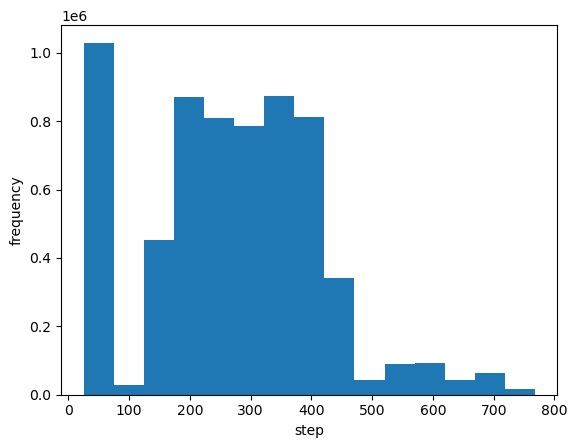

In [222]:
# histogram: "step"

histogram(df_bank, 'step', bins=15, yname='frequency')

24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:26:08 WARN RowBasedKeyValueBatch: Calling spill() on

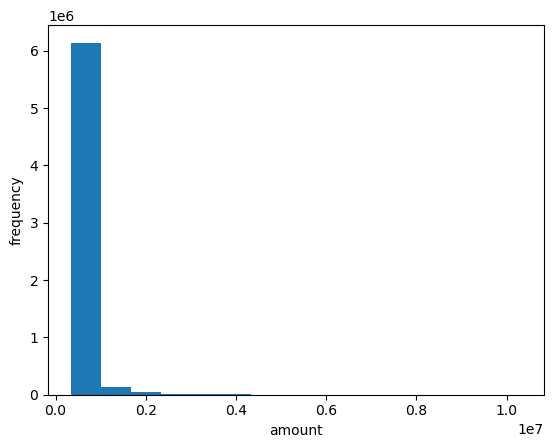

In [223]:
# histogram: "amount"

histogram(df_bank, 'amount', bins=15, yname='frequency')

24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:08:14 WARN RowBasedKeyValueBatch: Calling spill() on

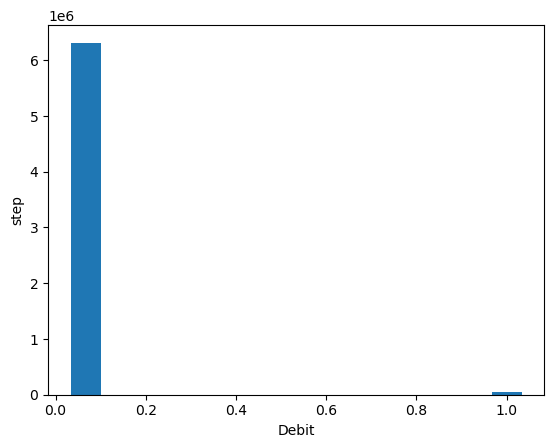

In [207]:
# histogram: "Debit"

histogram(df_bank, 'Debit', bins=15, yname='frequency')


24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:10:35 WARN RowBasedKeyValueBatch: Calling spill() on

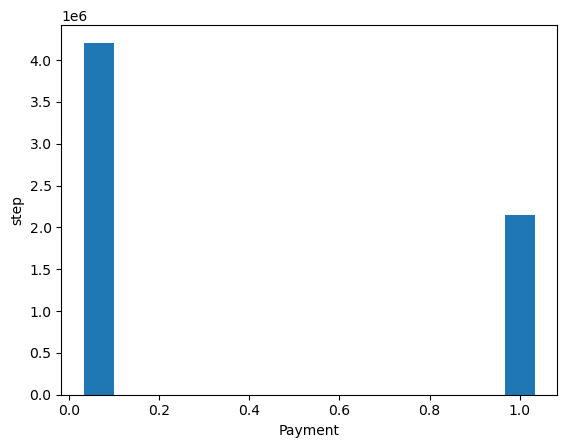

In [209]:
# histogram: "Payment"

histogram(df_bank, 'Payment', bins=15, yname='frequency')


24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:11:03 WARN RowBasedKeyValueBatch: Calling spill() on

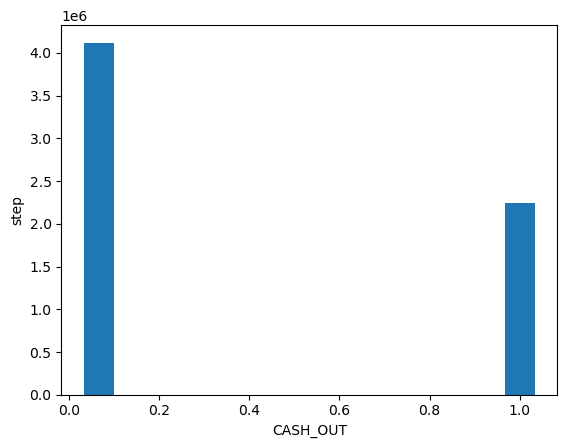

In [210]:
# histogram: "CASH_OUT"

histogram(df_bank, 'CASH_OUT', bins=15, yname='frequency')


24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:25 WARN RowBasedKeyValueBatch: Calling spill() on

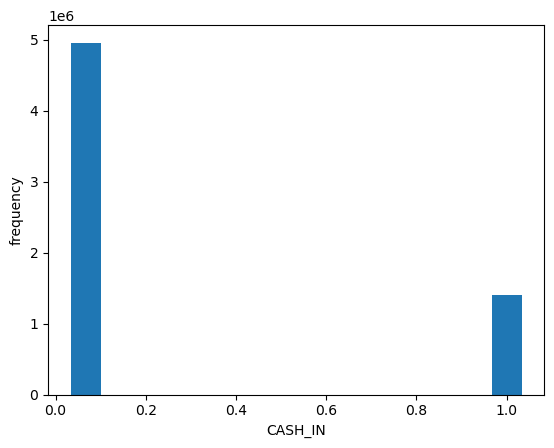

In [211]:
# histogram: "CASH_IN"

histogram(df_bank, 'CASH_IN', bins=15, yname='frequency')


24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:12:44 WARN RowBasedKeyValueBatch: Calling spill() on

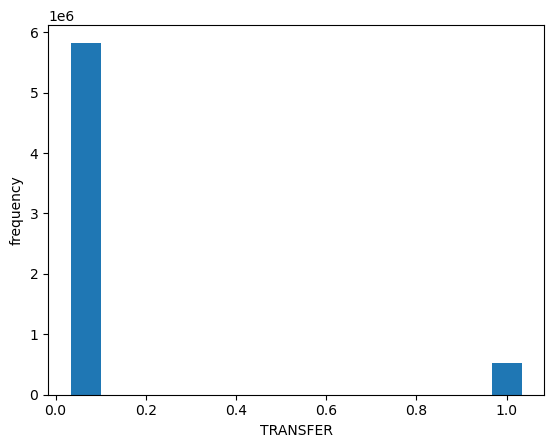

In [212]:
# histogram: "TRANSFER"

histogram(df_bank, 'TRANSFER', bins=15, yname='frequency')


24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:16 WARN RowBasedKeyValueBatch: Calling spill() on

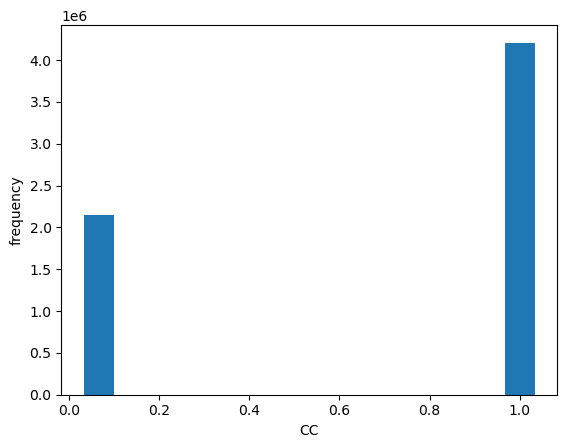

In [213]:
# histogram: "CC"

histogram(df_bank, 'CC', bins=15, yname='frequency')


24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:14:35 WARN RowBasedKeyValueBatch: Calling spill() on

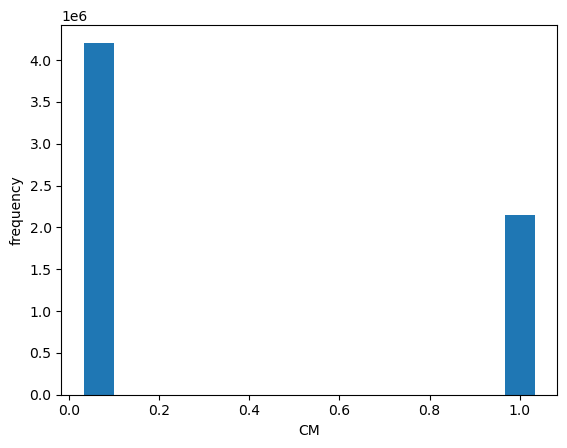

In [214]:
# histogram: "CM"

histogram(df_bank, 'CM', bins=15, yname='frequency')

24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 22:27:50 WARN RowBasedKeyValueBatch: Calling spill() on

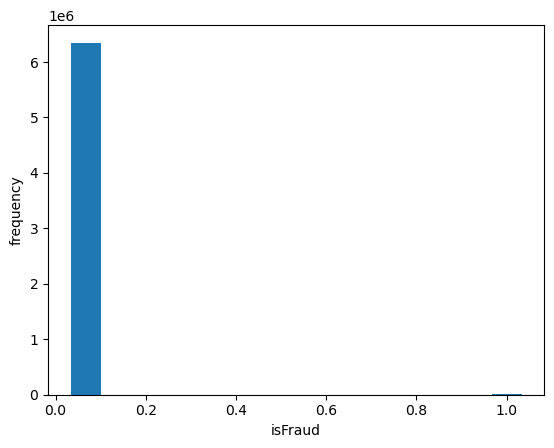

In [224]:
# histogram: "isFraud"

histogram(df_bank, 'isFraud', bins=15, yname='frequency')

#### Remember that our label is "isFraud", therefore, we can see that this class is unbalanced as we can see from the previous graphic. We need to perform an **Oversampling**.

In [258]:
### oversampling with "pysaprk"

minor_df = df_bank.filter(f.col("isFraud")==1)
major_df = df_bank.filter(f.col("isFraud")==0)

In [256]:
ratio = int(major_df.count()/minor_df.count())

24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:38:26 WARN RowBasedKeyValueBatch: Calling spill() on

In [257]:
print("The ratio is:",ratio)

The ratio is: 783


In [259]:
a = range(ratio)

In [260]:
# let´s duplicate the minoriry rows

oversampled_df = minor_df.withColumn("dummy",f.explode(f.array([f.lit(x) for x in a]))).drop("dummy")

In [261]:
oversampled_df.show(5)

+----+------+-------+--------+-------+-------+--------+-----+---+---+
|step|amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+------+-------+--------+-------+-------+--------+-----+---+---+
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
+----+------+-------+--------+-------+-------+--------+-----+---+---+
only showing top 5 rows



In [262]:
oversampled_df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- amount: integer (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- CASH_OUT: double (nullable = true)
 |-- PAYMENT: double (nullable = true)
 |-- CASH_IN: double (nullable = true)
 |-- TRANSFER: double (nullable = true)
 |-- DEBIT: double (nullable = true)
 |-- CC: double (nullable = true)
 |-- CM: double (nullable = true)



In [263]:
minor_df = oversampled_df.filter(f.col("isFraud")==1)

In [264]:
oversampled_df.count()

6344649

In [265]:
major_df.count()

24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:42:31 WARN RowBasedKeyValueBatch: Calling spill() on

6346920

In [266]:
combined_df = major_df.unionAll(oversampled_df)
combined_df.show(5)

24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:00 WARN RowBasedKeyValueBatch: Calling spill() on

+----+------+-------+--------+-------+-------+--------+-----+---+---+
|step|amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+------+-------+--------+-------+-------+--------+-----+---+---+
|   1| 51121|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1|373068|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1|  2643|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|   1| 95636|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1| 21898|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
+----+------+-------+--------+-------+-------+--------+-----+---+---+
only showing top 5 rows



In [267]:
combined_df.count()

24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:32 WARN RowBasedKeyValueBatch: Calling spill() on

12691569

In [268]:
combined_df.dropDuplicates()

DataFrame[step: int, amount: int, isFraud: int, CASH_OUT: double, PAYMENT: double, CASH_IN: double, TRANSFER: double, DEBIT: double, CC: double, CM: double]

In [269]:
combined_df.count()

24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:43:58 WARN RowBasedKeyValueBatch: Calling spill() on

12691569

In [ ]:
minor_df = combined_df.filter(f.col("isFraud")==1)
major_df = combined_df.filter(f.col("isFraud")==0)

In [270]:
minor_df.show(50)

+----+------+-------+--------+-------+-------+--------+-----+---+---+
|step|amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+------+-------+--------+-------+-------+--------+-----+---+---+
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   9|556218|      1

In [271]:
major_df.show(50)

24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:48:24 WARN RowBasedKeyValueBatch: Calling spill() on

+----+-------+-------+--------+-------+-------+--------+-----+---+---+
|step| amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|
+----+-------+-------+--------+-------+-------+--------+-----+---+---+
|   1|  51121|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1| 373068|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1|   2643|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|   1|  95636|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1|  21898|      0|     0.0|    0.0|    1.0|     0.0|  0.0|1.0|0.0|
|   1|  88987|      0|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|
|   1|   3545|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|   1|   1122|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|   1|   2637|      0|     0.0|    0.0|    0.0|     0.0|  1.0|1.0|0.0|
|   1|  16265|      0|     0.0|    1.0|    0.0|     0.0|  0.0|0.0|1.0|
|   1| 287509|      0|     0.0|    0.0|    0.0|     1.0|  0.0|1.0|0.0|
|   1|

In [272]:
minor_df.count()

6344649

In [273]:
major_df.count()

24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:49:12 WARN RowBasedKeyValueBatch: Calling spill() on

6346920

In [275]:
# now, we need to aggregate indexes to the "minor_df" dataframe

minor_df = minor_df.withColumn("index",monotonically_increasing_id())
minor_df.show(5)

+----+------+-------+--------+-------+-------+--------+-----+---+---+-----+
|step|amount|isFraud|CASH_OUT|PAYMENT|CASH_IN|TRANSFER|DEBIT| CC| CM|index|
+----+------+-------+--------+-------+-------+--------+-----+---+---+-----+
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|    0|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|    1|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|    2|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|    3|
|   9|556218|      1|     1.0|    0.0|    0.0|     0.0|  0.0|1.0|0.0|    4|
+----+------+-------+--------+-------+-------+--------+-----+---+---+-----+
only showing top 5 rows



In [ ]:
num_df_bank = df_bank.count()

In [279]:
num_df_bank

6355023

In [280]:
num_minor_df = round(num_df_bank/2)

In [281]:
num_minor_df

3177512

In [282]:
num_major_df = num_df_bank - num_minor_df

In [284]:
num_major_df

3177511

In [285]:
num_major_df + num_minor_df

6355023

In [286]:
# now, we need to establish which rows must be deleted
# dataframe: minor_df

rows_to_remove = []
for i in range(num_minor_df):
    rows_to_remove.append(i)

In [288]:
len(rows_to_remove)

3177512

In [289]:
minor_df = minor_df.filter(~minor_df.index.isin(rows_to_remove))

In [ ]:
minor_df.count()

In [ ]:
minor_df.show(50)

In [ ]:
# now, we need to establish which rows must be deleted
# dataframe: major_df

In [238]:
type(rows_to_remove)

list

In [245]:
rows_to_remove[0]

0

In [246]:
combined_df = combined_df.filter(~combined_df.index.isin(rows_to_remove))

In [247]:
combined_df.show(10)

24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:25:18 WARN RowBasedKeyValueBatch: Calling spill() on

+-------+-----+
|isFraud|index|
+-------+-----+
|      0| 1000|
|      0| 1001|
|      0| 1002|
|      0| 1003|
|      0| 1004|
|      0| 1005|
|      0| 1006|
|      0| 1007|
|      0| 1008|
|      0| 1009|
+-------+-----+
only showing top 10 rows



In [248]:
combined_df.count()

24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:26:11 WARN RowBasedKeyValueBatch: Calling spill() on

12690569

In [249]:
minor_df = combined_df.filter(f.col("isFraud")==1)
major_df = combined_df.filter(f.col("isFraud")==0)

In [251]:
minor_df.show(20)

24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:28:45 WARN RowBasedKeyValueBatch: Calling spill() on

+-------+-----------+
|isFraud|      index|
+-------+-----------+
|      1|94489280512|
|      1|94489280513|
|      1|94489280514|
|      1|94489280515|
|      1|94489280516|
|      1|94489280517|
|      1|94489280518|
|      1|94489280519|
|      1|94489280520|
|      1|94489280521|
|      1|94489280522|
|      1|94489280523|
|      1|94489280524|
|      1|94489280525|
|      1|94489280526|
|      1|94489280527|
|      1|94489280528|
|      1|94489280529|
|      1|94489280530|
|      1|94489280531|
+-------+-----------+
only showing top 20 rows



In [252]:
major_df.show(20)

24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:01 WARN RowBasedKeyValueBatch: Calling spill() on

+-------+-----+
|isFraud|index|
+-------+-----+
|      0| 1000|
|      0| 1001|
|      0| 1002|
|      0| 1003|
|      0| 1004|
|      0| 1005|
|      0| 1006|
|      0| 1007|
|      0| 1008|
|      0| 1009|
|      0| 1010|
|      0| 1011|
|      0| 1012|
|      0| 1013|
|      0| 1014|
|      0| 1015|
|      0| 1016|
|      0| 1017|
|      0| 1018|
|      0| 1019|
+-------+-----+
only showing top 20 rows



In [253]:
minor_df.count()

24/05/10 23:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:38 WARN RowBasedKeyValueBatch: Calling spill() on

6344649

In [254]:
major_df.count()

24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:29:52 WARN RowBasedKeyValueBatch: Calling spill() on

6345920

In [234]:
rows_to_remove = [0:10]

In [235]:
combined_df = combined_df.filter(~combined_df.index.isin(rows_to_remove))

In [236]:
combined_df.show(20)

24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/05/10 23:21:05 WARN RowBasedKeyValueBatch: Calling spill() on

+-------+-----+
|isFraud|index|
+-------+-----+
|      0|    1|
|      0|    2|
|      0|    3|
|      0|    4|
|      0|    5|
|      0|    6|
|      0|    7|
|      0|    8|
|      0|    9|
|      0|   10|
|      0|   11|
|      0|   12|
|      0|   13|
|      0|   14|
|      0|   15|
|      0|   16|
|      0|   17|
|      0|   18|
|      0|   19|
|      0|   20|
+-------+-----+
only showing top 20 rows



#### Now, we´ll transform it to a Pandas dataframe.

In [ ]:
df_bank_partitioned_pd = df_bank_partitioned.toPandas()

In [142]:
type(df_bank_partitioned)

pyspark.sql.dataframe.DataFrame

In [146]:
counter = Counter(df_bank_partitioned_pd['isFraud'])

In [149]:
counter

Counter({0: 6346920, 1: 8103})

In [ ]:
df_bank_partitioned_pd.describe()

In [ ]:
df_bank_partitioned_pd.head(5)

In [ ]:
df_bank_partitioned_pd.info()

#### From the previous view, we can see that the columns have only "object" type. We need to cast it into integers using the method "astype()".

In [ ]:
df_bank_partitioned_pd['isFraud'] = df_bank_partitioned_pd['isFraud'].astype(int)

In [ ]:
df_bank_partitioned_pd['isFraud']

#### We can see that the type has been changed from "object" to "int64" (integer).

In [ ]:
df_bank_partitioned_pd.plot.hist()

In [126]:
#
len(df_bank_partitioned_pd)


6355023

#### From the previous plot we can see that the classes are unbalanced. Remember that "0" means that there is no fraud and "1" is the opposite case. We need to apply a technique to revert this. We´ll use an algorithm named "SMOTE". 

In [ ]:
# create an object "SMOTE"

smt = SMOTE()

#### Let´s split the dataset into two pieces: "X" and "Y". 

In [130]:
X_train, X_test,y_train,y_test = train_test_split(df_bank_partitioned_pd,df_bank_partitioned_pd,test_size=0.4)

In [132]:
X_train, X_test

(         isFraud
 5964088        0
 2457836        0
 96755          0
 4573039        0
 3689553        1
 ...          ...
 3933562        0
 4593022        0
 378849         0
 3792277        0
 3558182        0
 
 [3813013 rows x 1 columns],
          isFraud
 484577         0
 4625188        0
 1678078        0
 6024382        0
 487962         0
 ...          ...
 1011947        0
 4353655        0
 905713         0
 2778079        0
 3677745        0
 
 [2542010 rows x 1 columns])

In [ ]:
len(X_train),len(y_train)

In [ ]:
len(X_test),len(y_test)

#### Suming both results in 6.35

In [138]:
X_resampled, Y_resambled = smt.fit_resample(X_train,y_train)

In [ ]:
smt.fit

In [ ]:
type(X_resampled)

In [139]:
len(X_resampled)

7616226

In [135]:
Counter(df_bank_partitioned_pd['isFraud'])

Counter({0: 6346920, 1: 8103})

In [136]:
Counter(X_resampled['isFraud'])

Counter({0: 3808192, 1: 3808192})

In [137]:
Counter(Y_resambled['isFraud'])

Counter({0: 3808192, 1: 3808192})

In [ ]:
X_resampled

In [ ]:
len(X_resampled)

In [ ]:
Y_resambled

array([[<Axes: title={'center': 'isFraud'}>]], dtype=object)

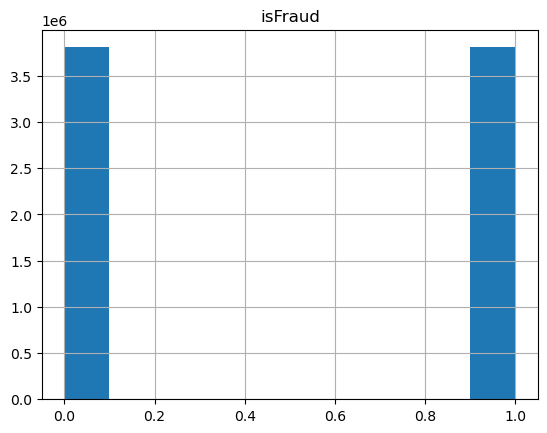

In [190]:
X_resampled.hist()

In [191]:
X_resampled.count()

isFraud    7616226
dtype: int64

In [193]:
Counter(X_resampled['isFraud'])

Counter({0: 3808113, 1: 3808113})

In [ ]:
len(X_resampled)

In [ ]:
len(Y_resambled)

In [ ]:
df_bank_partitioned_pd['isFraud']

In [ ]:
values0,value1 = df_bank_partitioned_pd.isFraud.value_counts()

In [ ]:
values0,value1

In [ ]:
df_class_0 = df_bank_partitioned_pd[df_bank_partitioned_pd['isFraud']==0]
df_class_1 = df_bank_partitioned_pd[df_bank_partitioned_pd['isFraud']==1]


In [ ]:
df_class_0, df_class_1 

In [ ]:
### Random over-sampling

df_class_1_overSampling = df_class_1.sample(values0, replace=True)

In [ ]:
df_class_1_overSampling

In [ ]:
df_test_overSampling = pd.concat([df_class_0,df_class_1_overSampling],axis=0)

In [ ]:
type(df_test_overSampling)

In [ ]:
df_test_overSampling.isFraud.value_counts()

array([[<Axes: title={'center': 'isFraud'}>]], dtype=object)

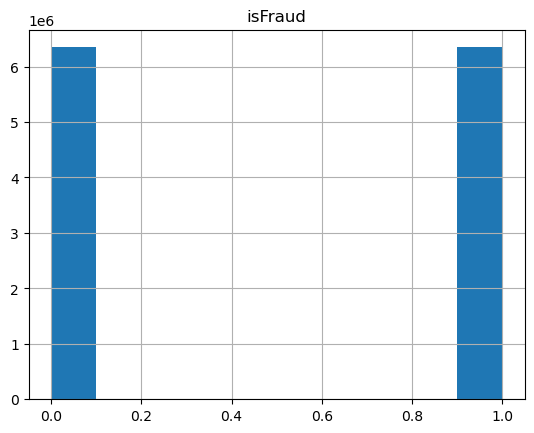

In [124]:
df_test_overSampling.hist()

In [128]:
### RandonOverSampler (inmlearn)

ros = RandomOverSampler()


In [134]:
X_ros , y_ros = ros.fit_resample(X_train,X_test)

ValueError: Length mismatch: Expected axis has 5077614 elements, new values have 6348617 elements